In [1]:
import os

# get classes
data_set_path = 'data/data_set'
classes = [
        c for c in os.listdir(data_set_path)
        if not c.startswith('.')
        and os.path.isdir(os.path.join(data_set_path, c))
]

In [2]:
# get video files
video_dict = dict()
for class_ in classes:
    class_path = os.path.join(data_set_path, class_)
    video_dict[class_] = tuple(
            v for v in os.listdir(class_path)
            if not v.startswith('.')
            and os.path.isfile(os.path.join(class_path, v))
    )

In [3]:
# trun off vertical list printing
%pprint

Pretty printing has been turned OFF


In [4]:
# check the content of a specific class
video_dict.get('car')

('20160603_133515.mp4', '20160706_180451.mp4', 'IMG_3114.MOV', 'PIC_10265721554095715992.MOV', 'V60722-153427.mp4', 'V60722-153449.mp4', 'V60722-153513.mp4', 'V60722-153539.mp4', 'V60722-153720.mp4', 'V60722-153743.mp4', 'V60722-154202.mp4', 'V60722-190302.mp4', 'V60722-190605.mp4', 'V60722-190631.mp4', 'V60722-190716.mp4', 'V60722-190739.mp4', 'V60722-190820.mp4', 'V60722-191413.mp4', 'V60722-191454.mp4', 'V60722-191627.mp4', 'V60722-191709.mp4', 'video_20160722_153539.mp4', 'video_20160722_190554.mp4')

In [5]:
from torchvision import models

# get network
resnet_18 = models.resnet18(pretrained=True)
resnet_18.eval();
resnet_18.cuda();

In [6]:
from torchvision import transforms as trn

# define image transformation
pre_proc = trn.Compose([
        trn.ToPILImage(),
        trn.Scale(256),
        trn.CenterCrop(224),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
# create hook
avgpool_layer = resnet_18._modules.get('avgpool')
h = avgpool_layer.register_forward_hook(lambda m,i,o: my_embedding.append(o.data.view(1, -1)))

In [8]:
import torch
from torch.autograd import Variable as V
from torch.nn.functional import softmax
from ipywidgets import IntProgress
from IPython.display import display
from skvideo.io import FFmpegReader

embedding_and_probs_dict = dict()

# for c, class_ in enumerate(classes):
class_ = 'car'
embedding_and_probs_dict[class_] = dict()
class_path = os.path.join(data_set_path, class_)

video_nb = len(video_dict[class_])
video_prg_bar = IntProgress(min=0, max=video_nb, bar_style='success',
                            description='video 1/' + str(video_nb))
display(video_prg_bar)
frame_prg_bar = IntProgress(min=0, max=0, description='frame'); display(frame_prg_bar)
for video_name in video_dict[class_]:
    video_prg_bar.description = 'video ' + str(video_prg_bar.value+1) + '/' + str(len(video_dict[class_]))
    # start at a given index
#     if video_prg_bar.value < 21:
#         video_prg_bar.value += 1
#         video_prg_bar.description = 'video ' + str(video_prg_bar.value+1) + '/' + str(len(video_dict[class_]))
#         continue
    video_path = os.path.join(class_path, video_name)
    video_file = FFmpegReader(video_path)
    frames_nb = video_file.getShape()[0]
    my_embedding = list()
    my_probabilities = list()

    frame_prg_bar.max = frames_nb
    frame_prg_bar.value = 0
    frame_prg_bar.description = 'frame 1/' + str(frames_nb)
    
    for frame in video_file.nextFrame():
        frame_prg_bar.description = 'frame ' + str(frame_prg_bar.value+1) + '/' + str(frames_nb)
        x = V(pre_proc(frame).unsqueeze(0).cuda(), volatile=True)
        logit = resnet_18(x)
        my_probabilities.append(softmax(logit).data)
        frame_prg_bar.value += 1
        # hack for buggy video files
        if video_name == 'V60722-191627.mp4' and frame_prg_bar.value + 1 == frames_nb: break

    embedding_and_probs_dict[class_][video_name] = {
            'emb': torch.cat(my_embedding, 0).cpu(),
            'prb': torch.cat(my_probabilities, 0).cpu()
    }
    video_prg_bar.value += 1

In [9]:
torch.save(embedding_and_probs_dict, 'emb_prb.pth.tar')
# embedding_and_probs_dict = torch.load('emb_prb.pth.tar')

In [10]:
# remove hook
h.remove()

In [11]:
import os

# get classes labels
classes_file_name = 'synset_words.txt'
if not os.access(classes_file_name, os.W_OK):
    synset_URL = 'https://github.com/szagoruyko/functional-zoo/raw/master/synset_words.txt'
    os.system('wget ' + synset_URL)

classes = list()
with open(classes_file_name) as f:
    for line in f:
        classes.append(line.strip().split(' ', 1)[1].split(', ')[0])
classes = tuple(classes)

In [12]:
# return top N indeces
def get_top_n_idx(p, N=5):
    probs, idx = p.sort(0, True)
    return idx[:N]

In [13]:
# matplotlib and stuff
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

# configurations for dark background
plt.style.use(['dark_background', 'bmh'])

# configuration for bright background
# plt.style.use('bmh')

# remove background colour, set figure size
rc('figure', figsize=(16, 8), facecolor='none', max_open_warning=False)
rc('axes', facecolor='none')

In [14]:
# create the car_embedding Tensor
car_embedding = torch.cat(tuple(embedding_and_probs_dict['car'][a_key]['prb']
        for a_key in embedding_and_probs_dict['car'].keys()), 0)

In [15]:
from matplotlib.mlab import PCA as mlabPCA

# perform PCA on car_embedding
mlab_pca = mlabPCA(car_embedding.numpy())

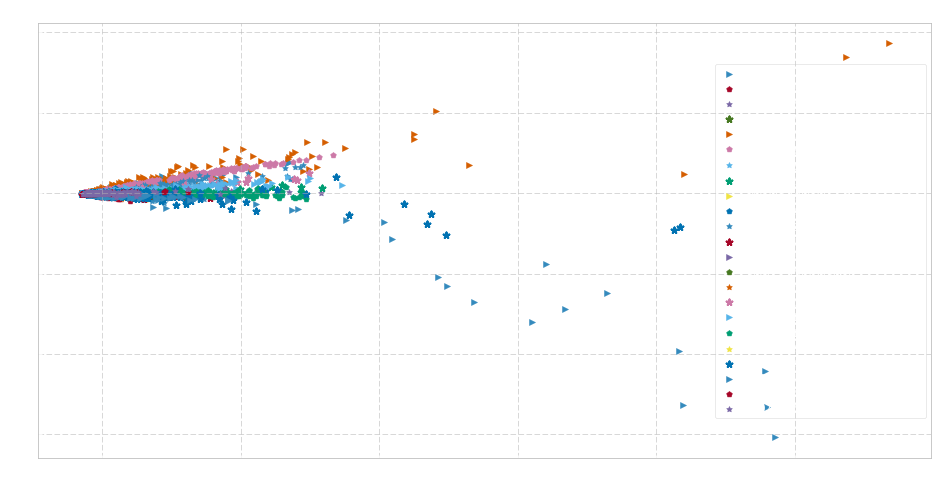

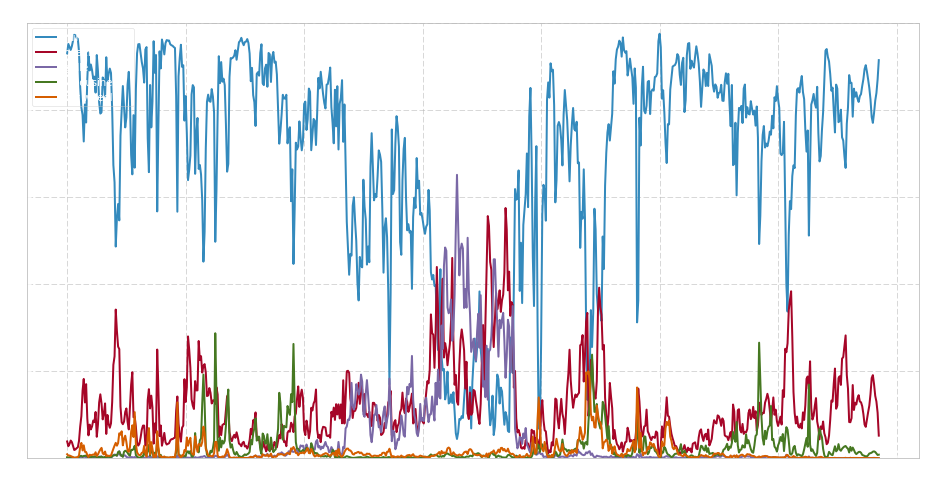

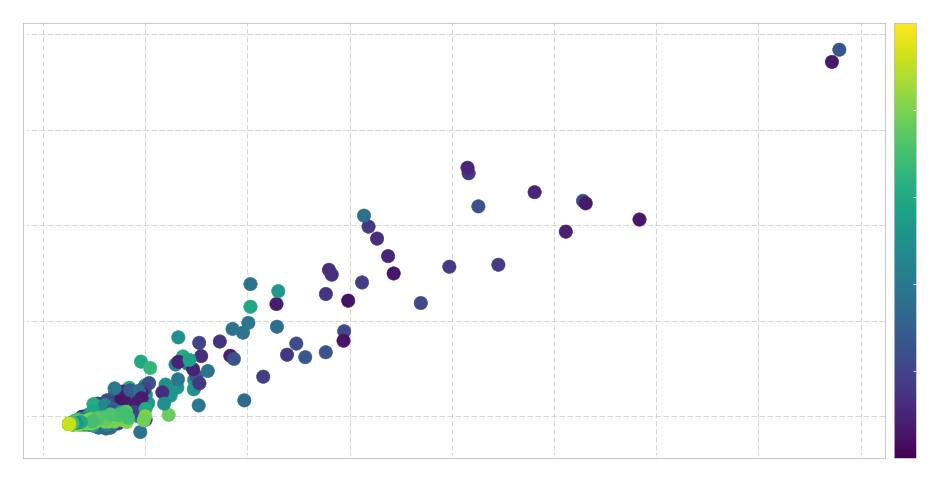

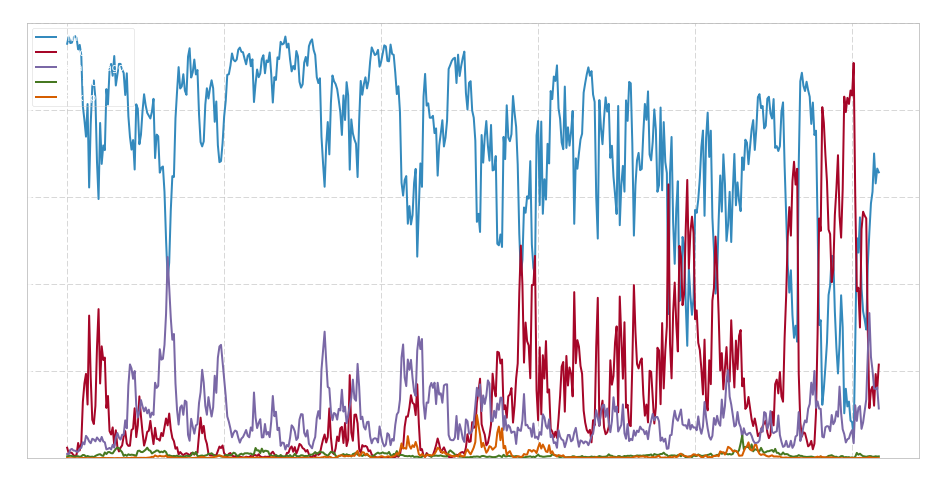

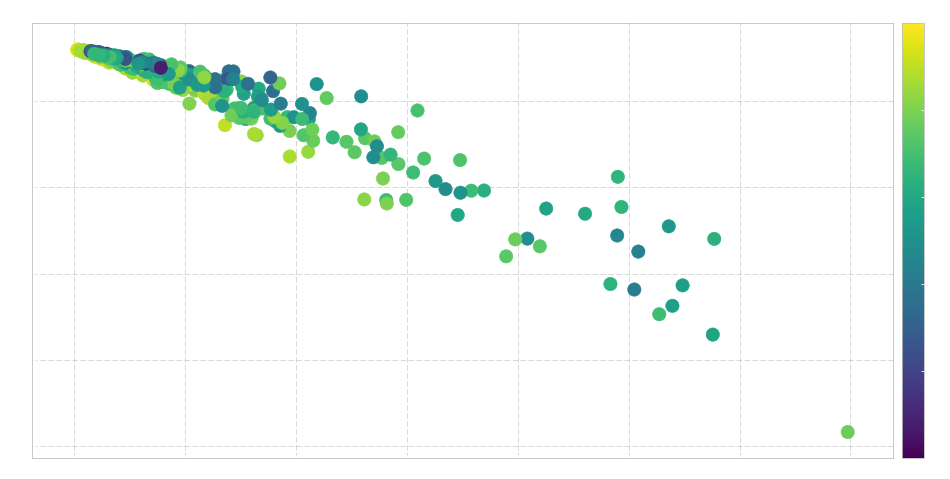

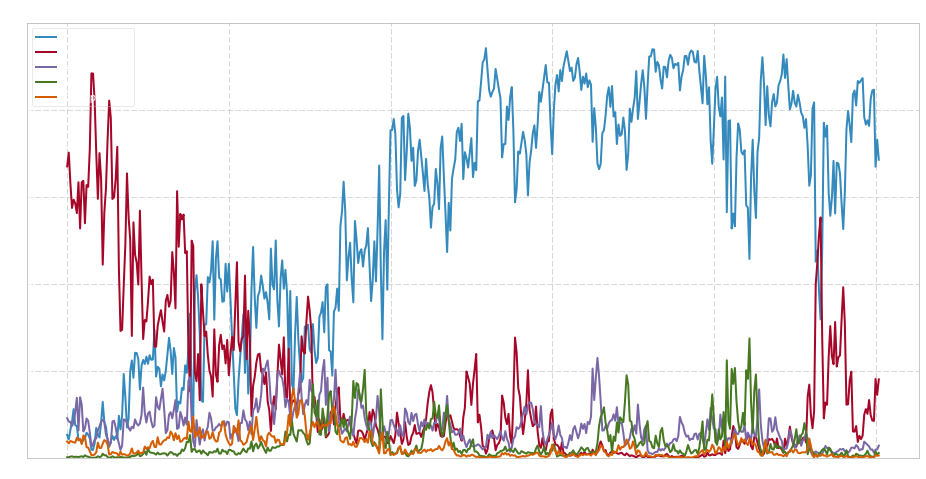

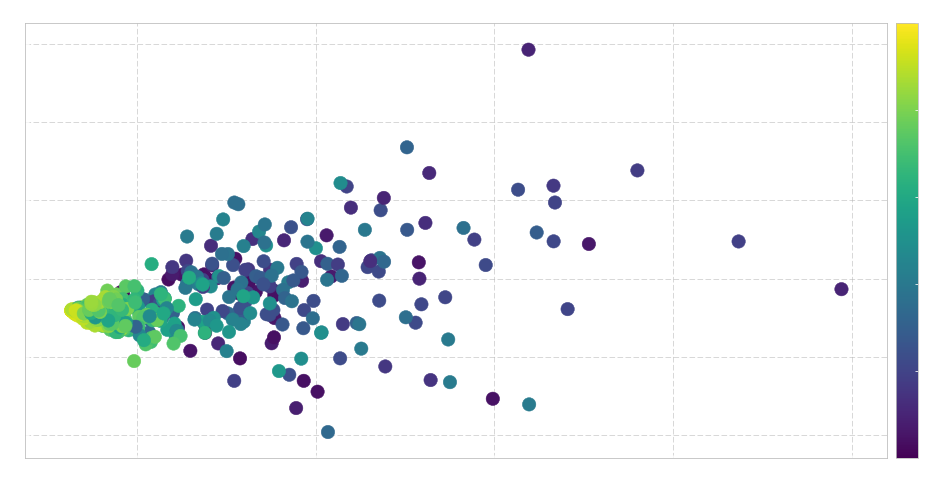

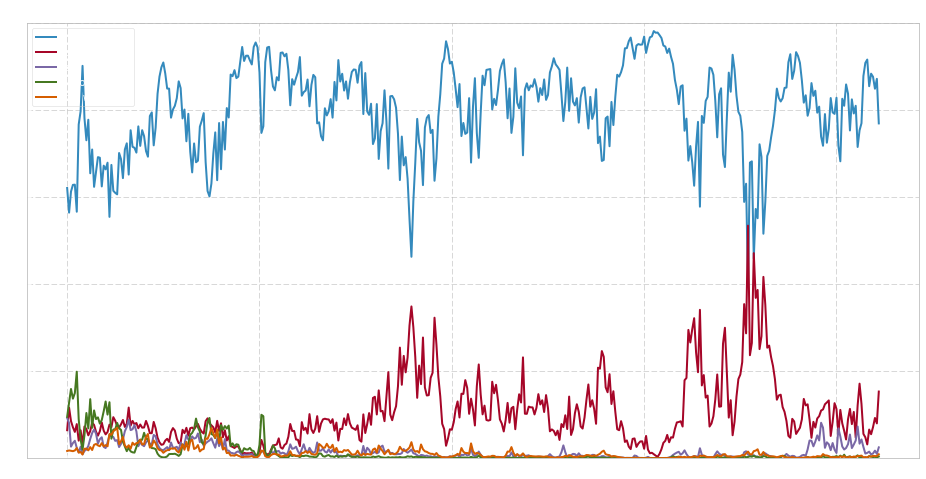

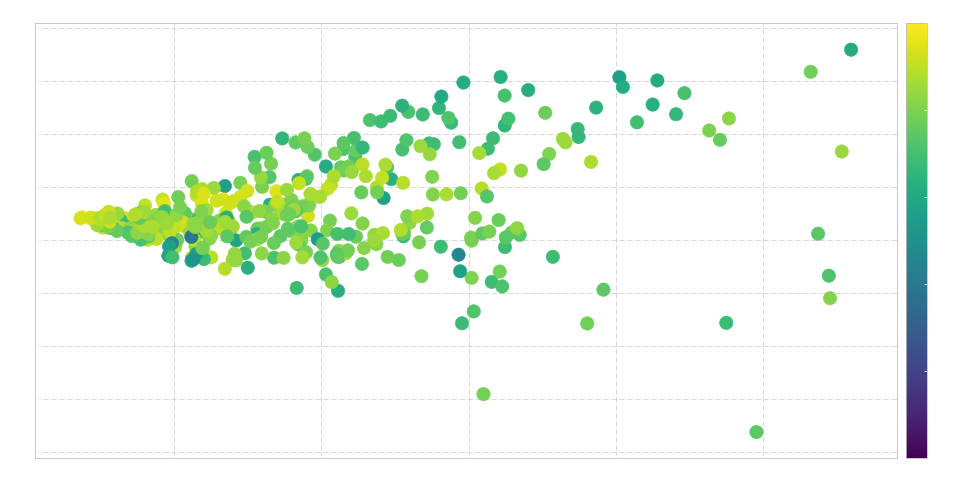

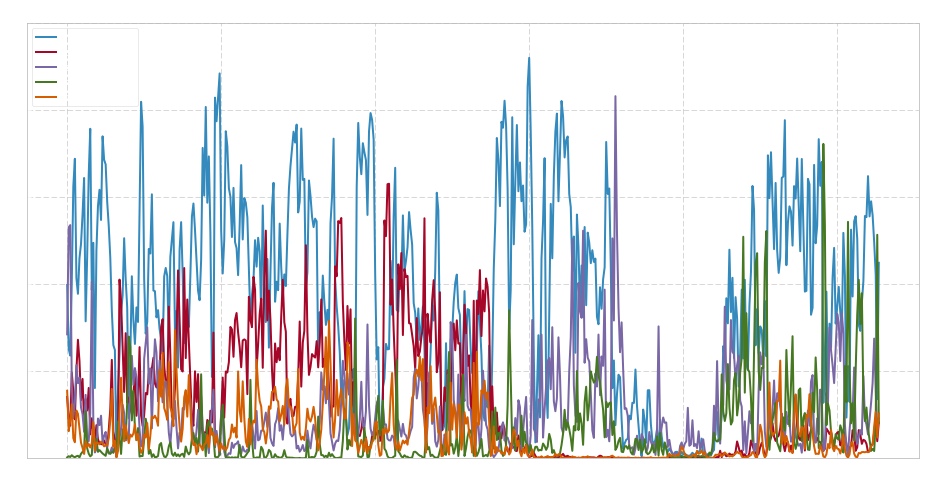

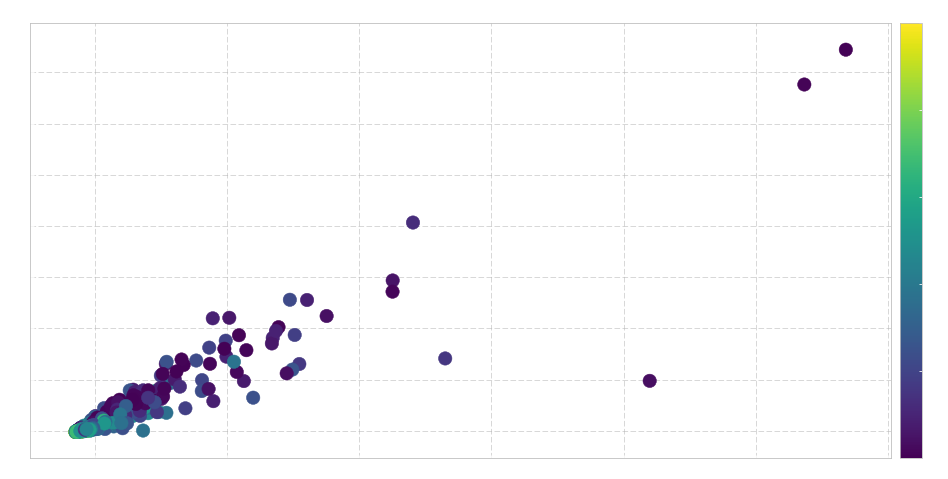

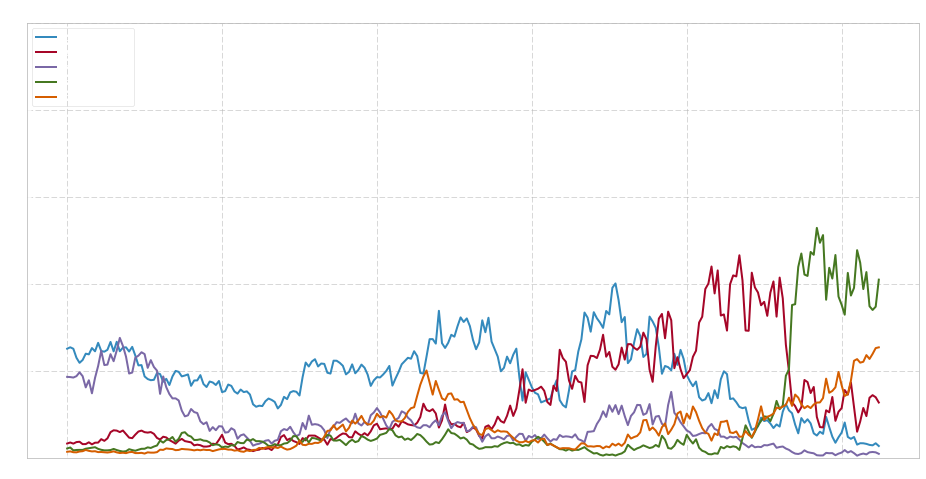

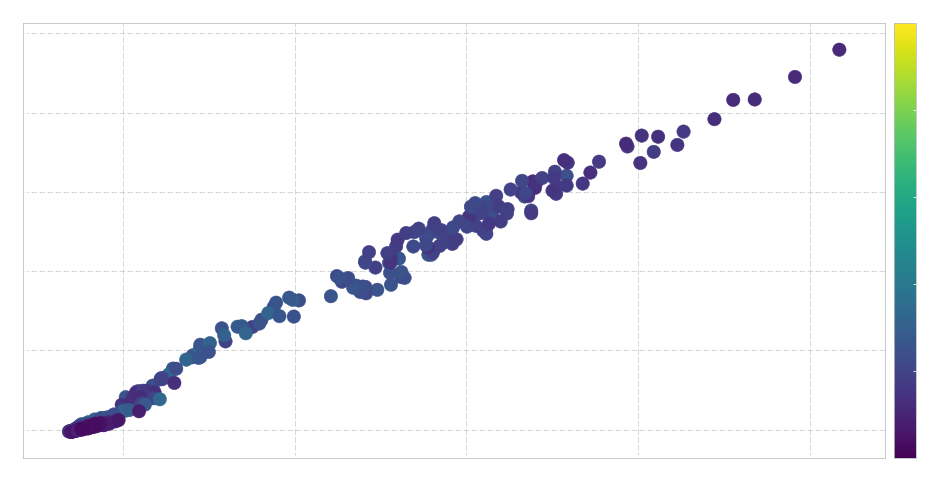

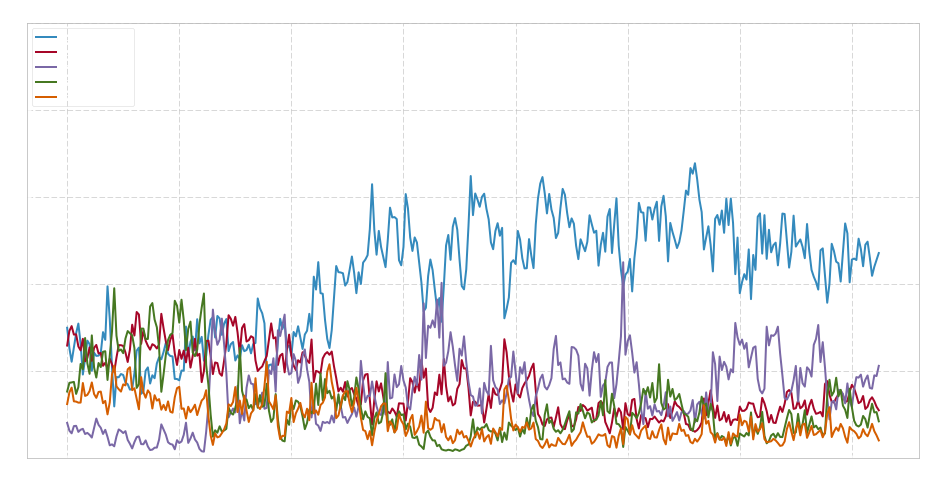

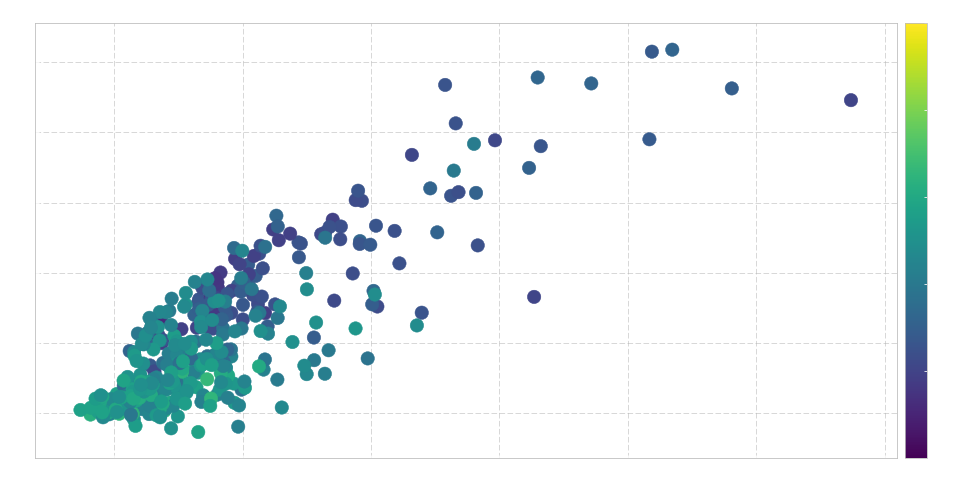

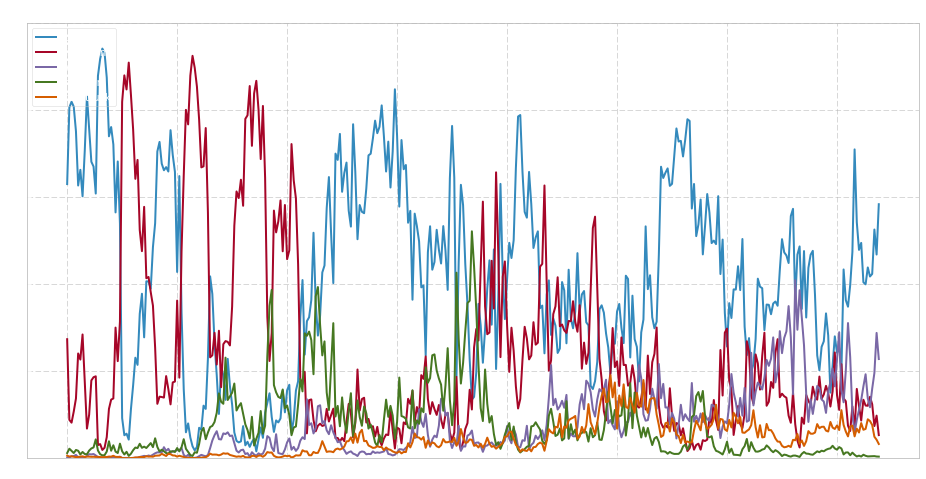

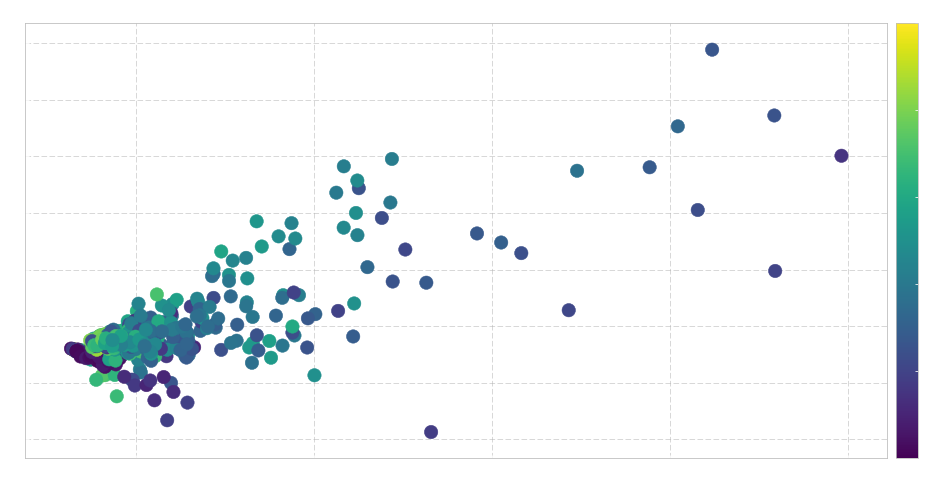

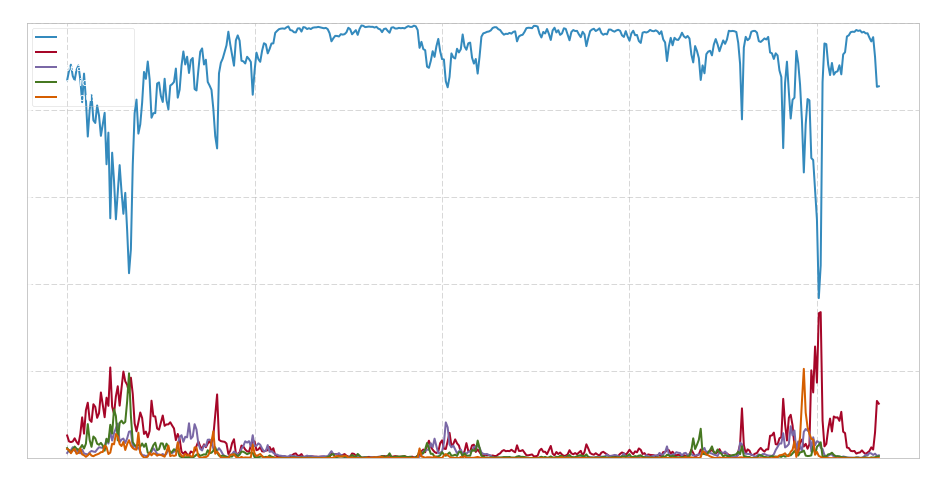

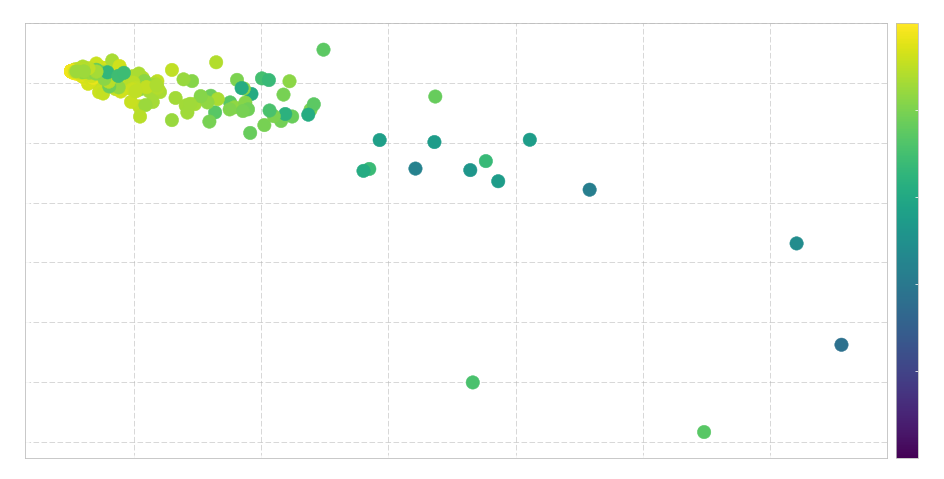

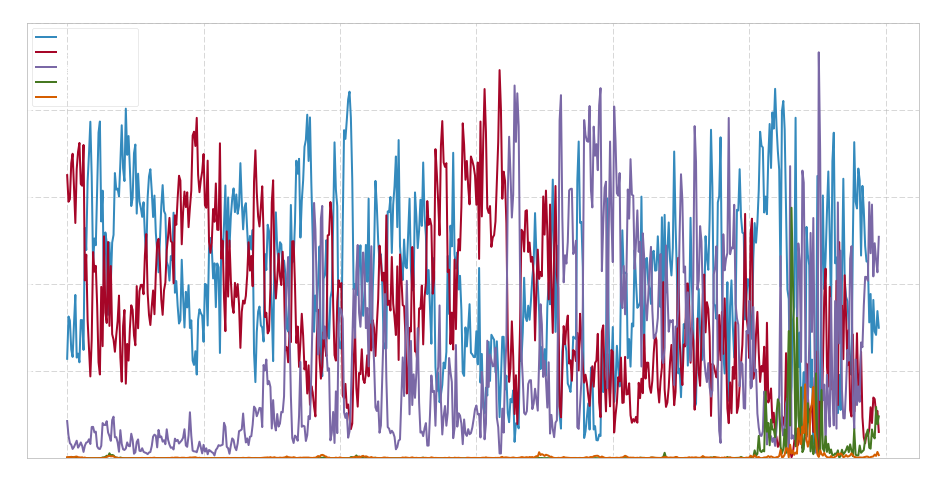

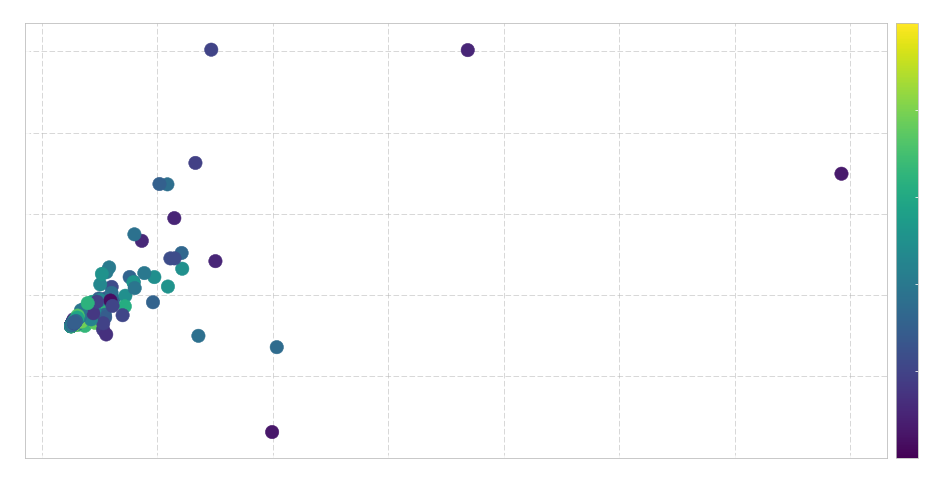

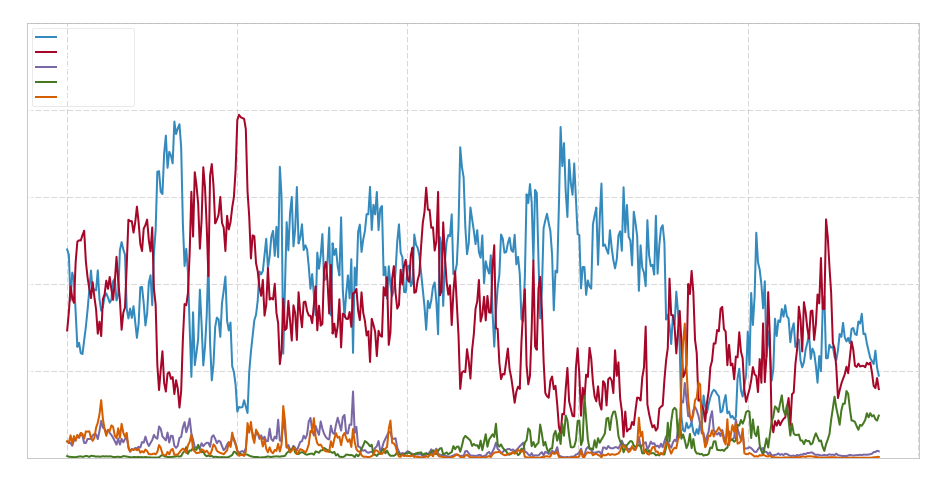

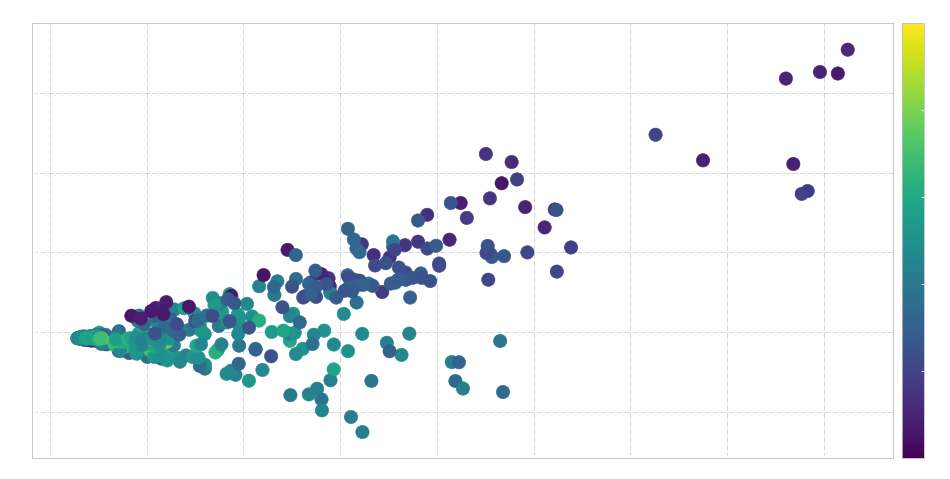

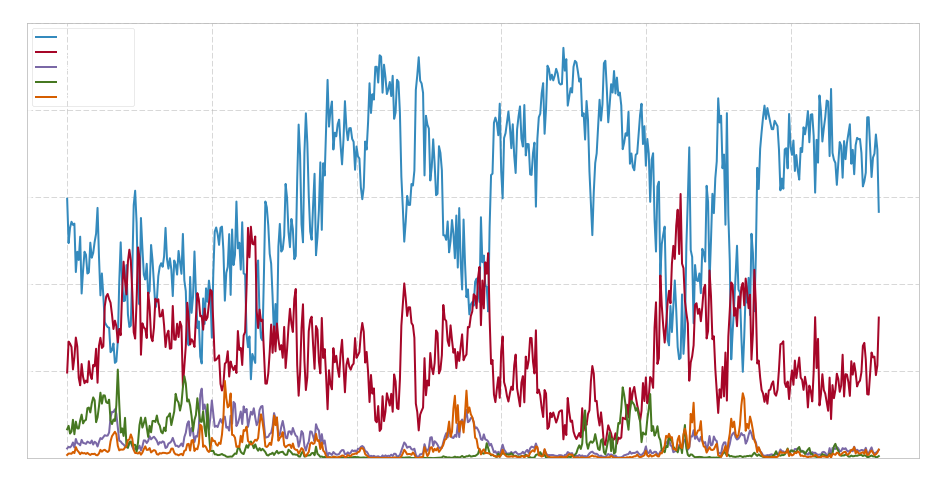

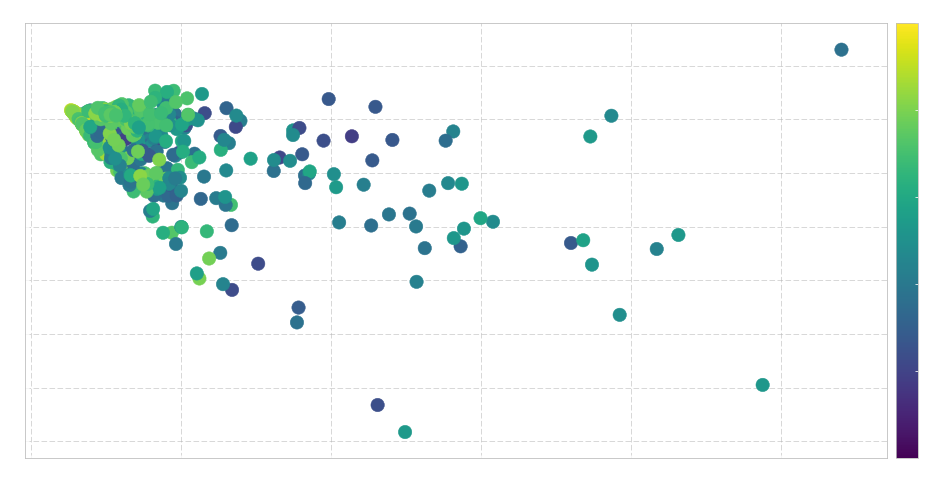

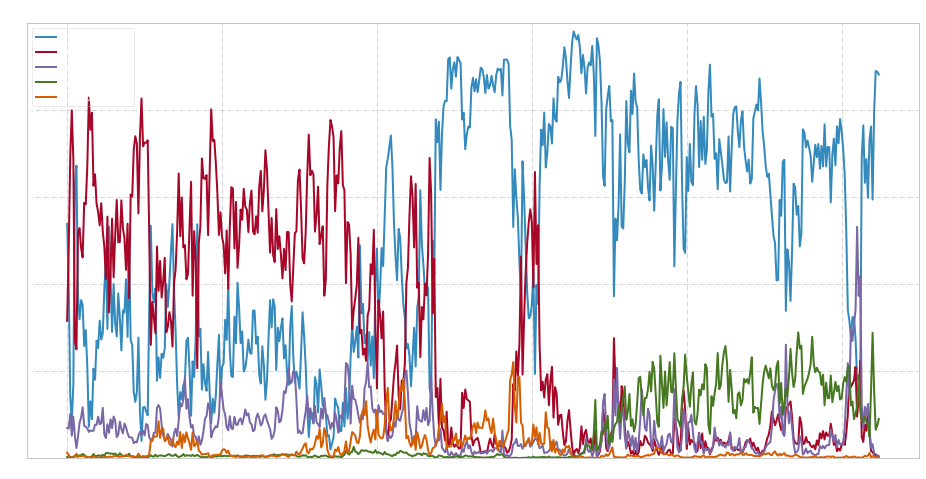

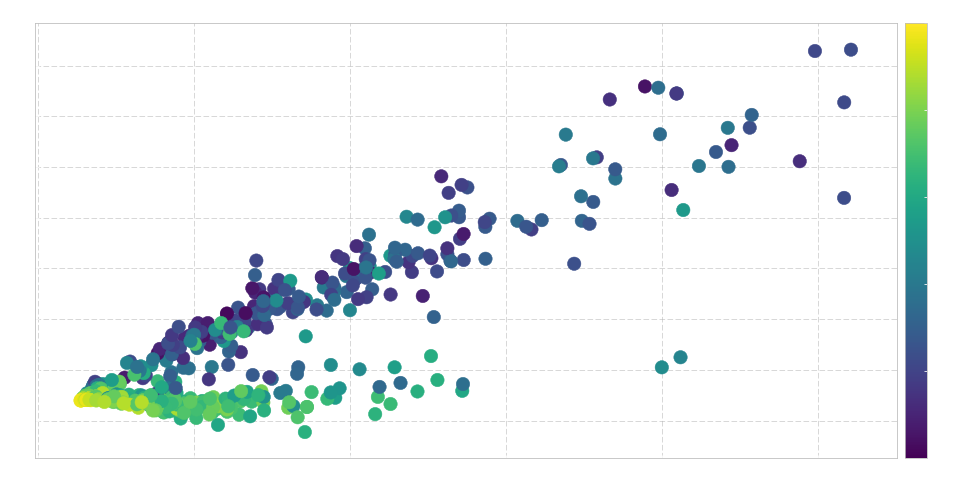

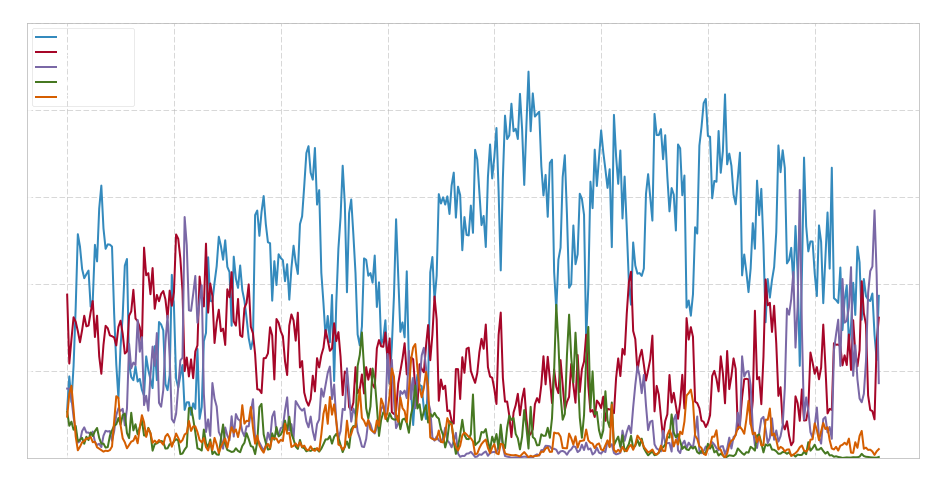

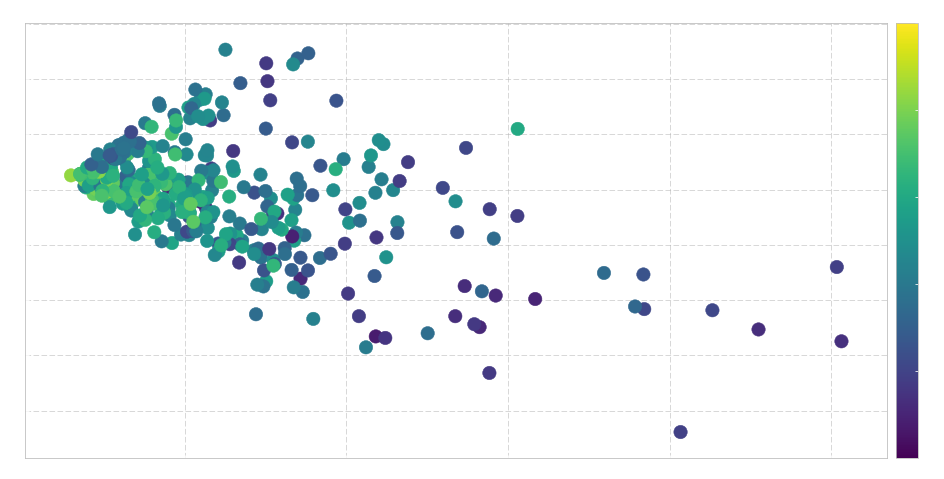

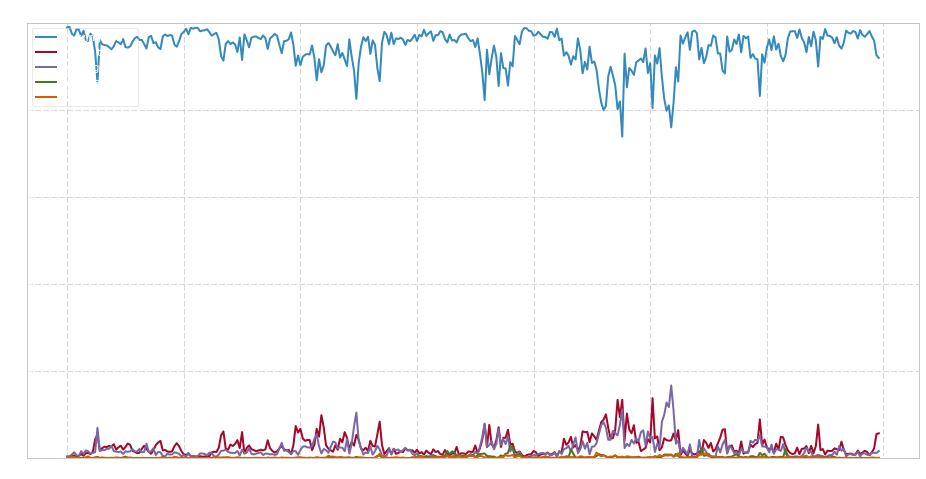

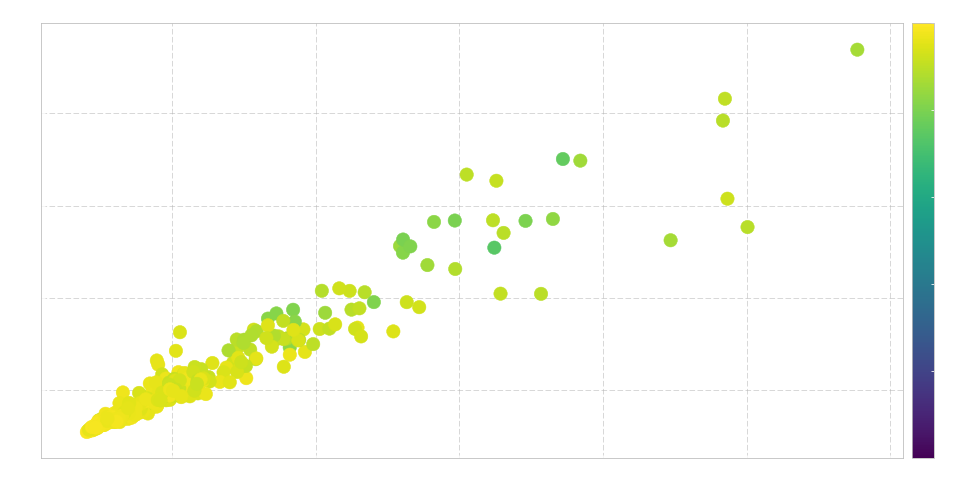

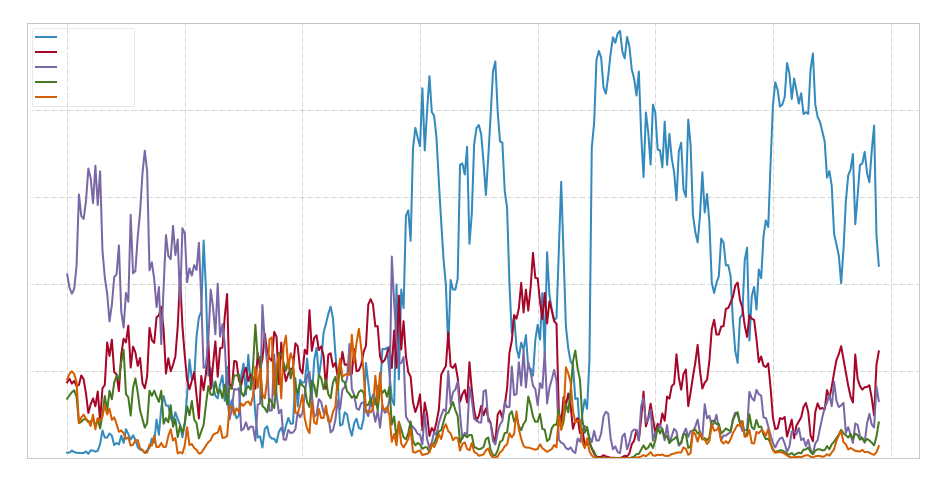

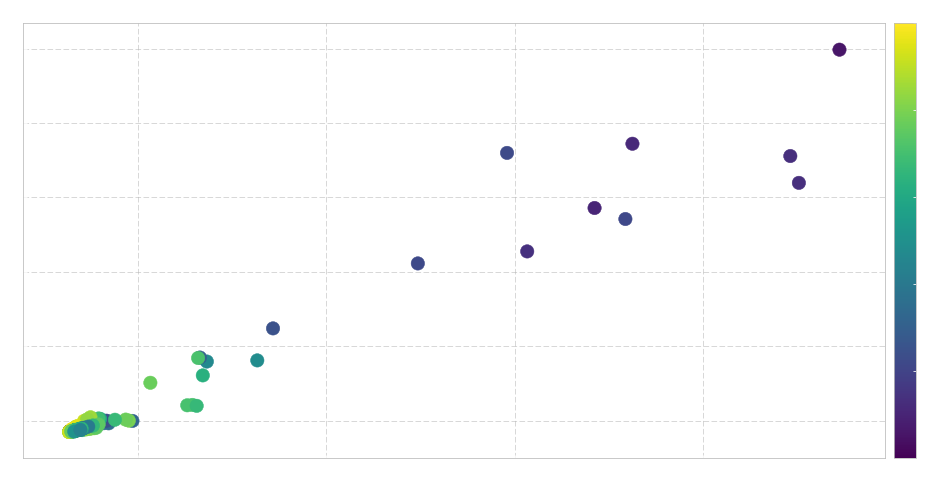

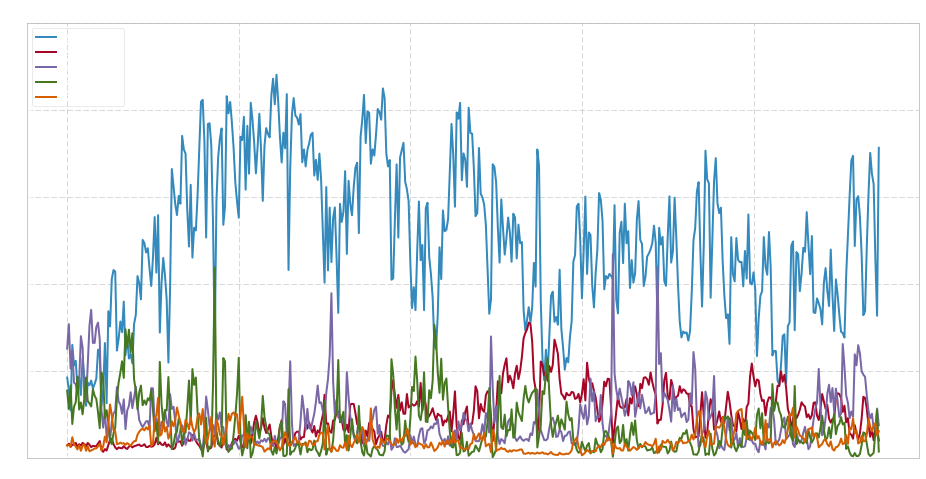

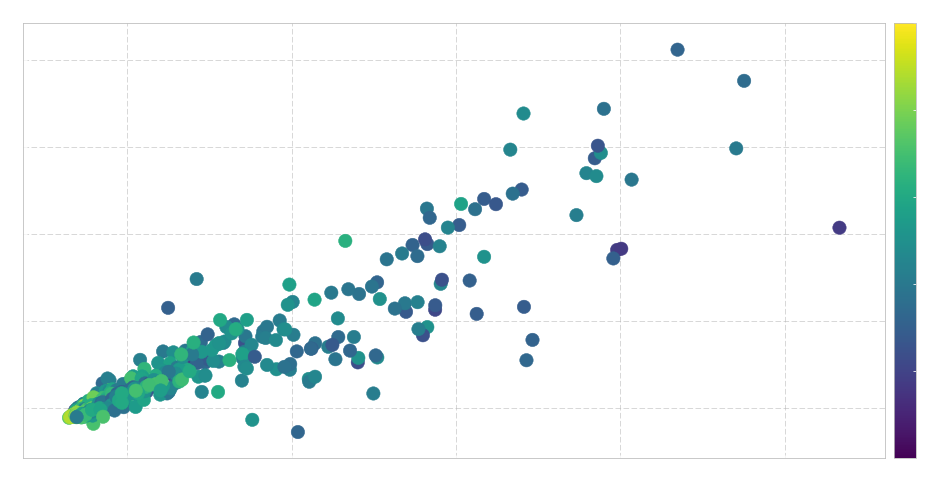

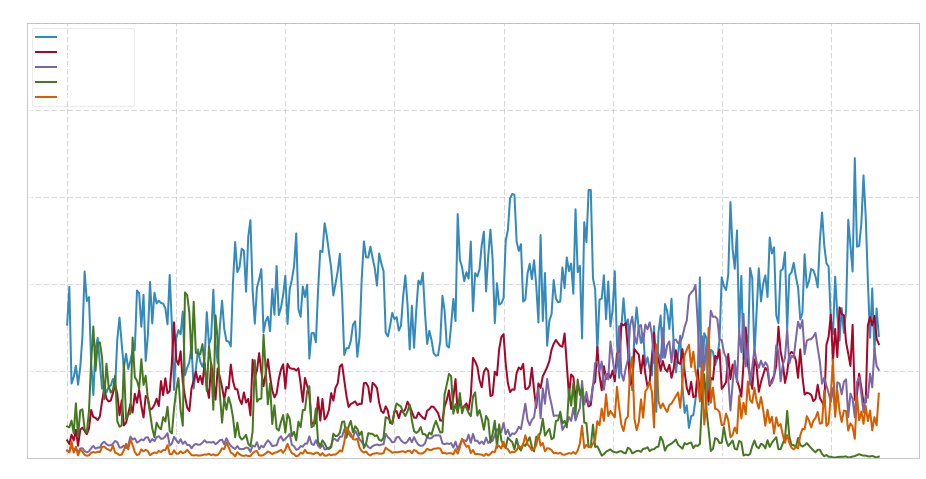

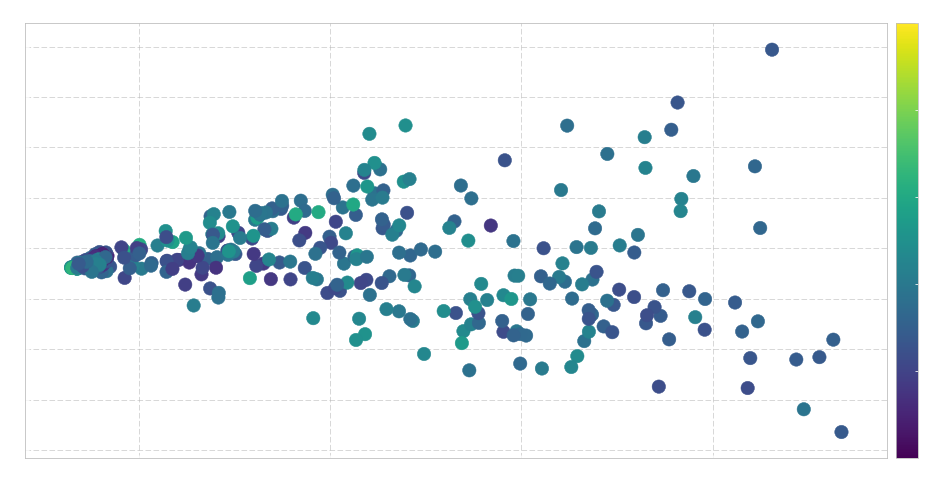

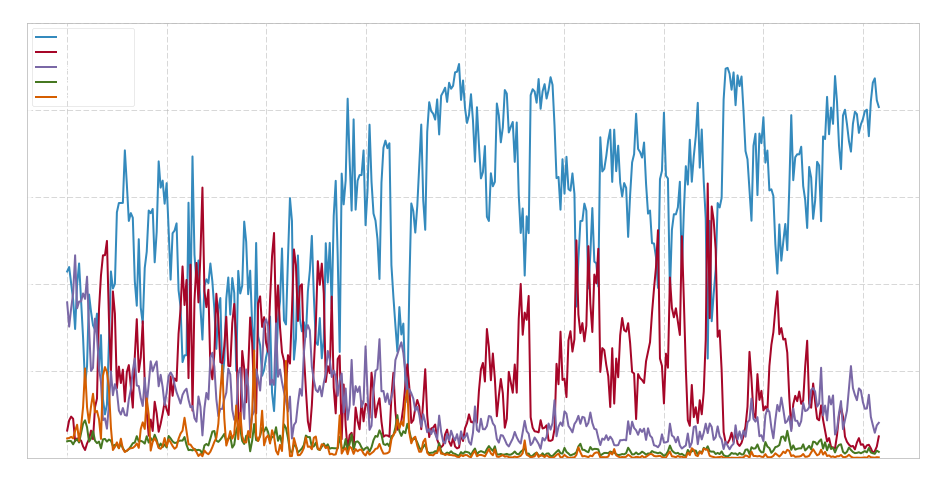

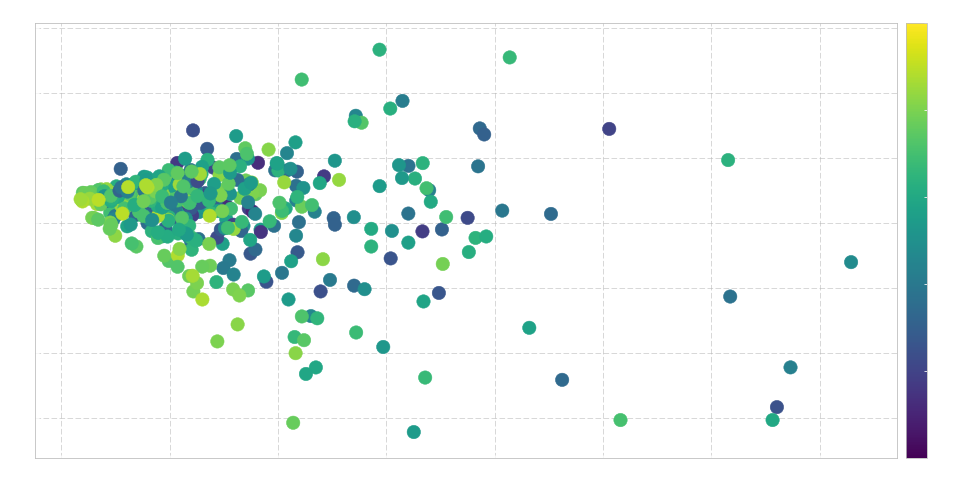

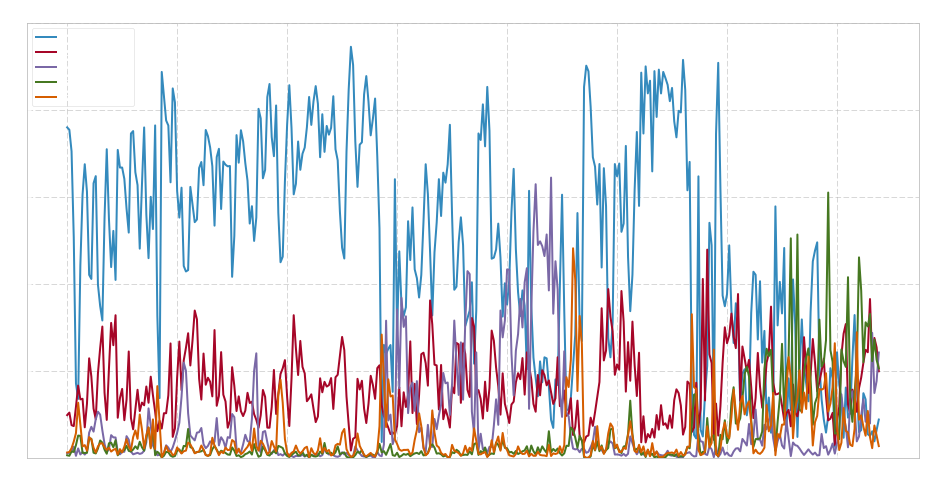

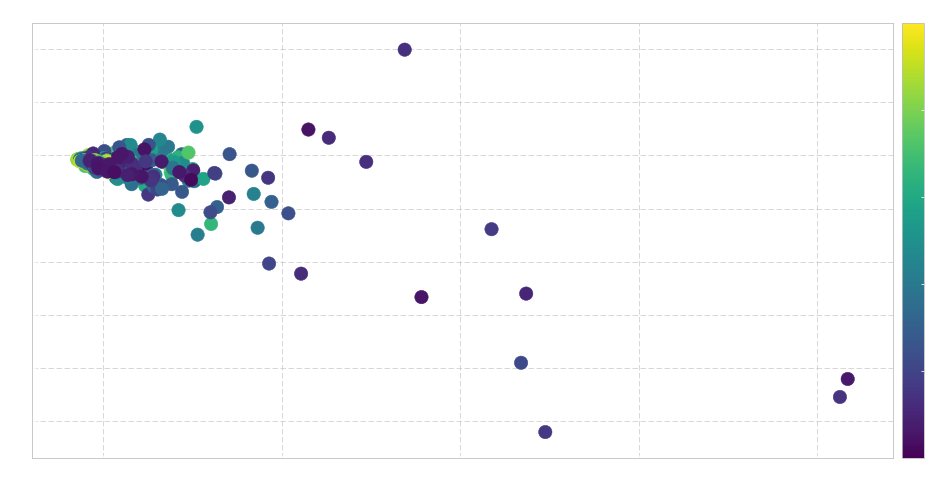

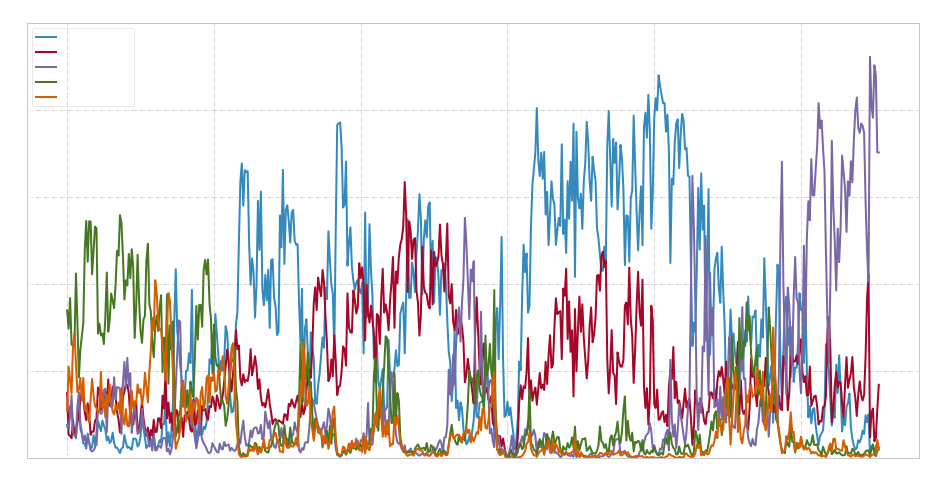

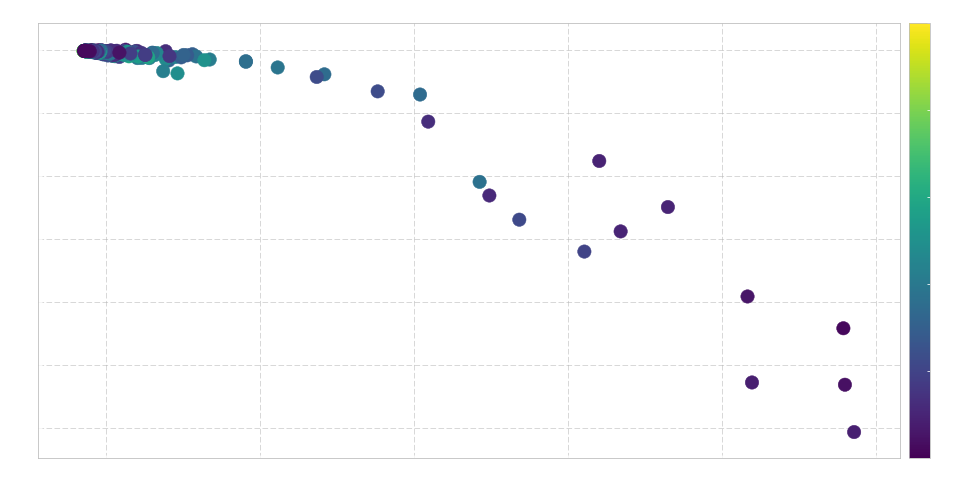

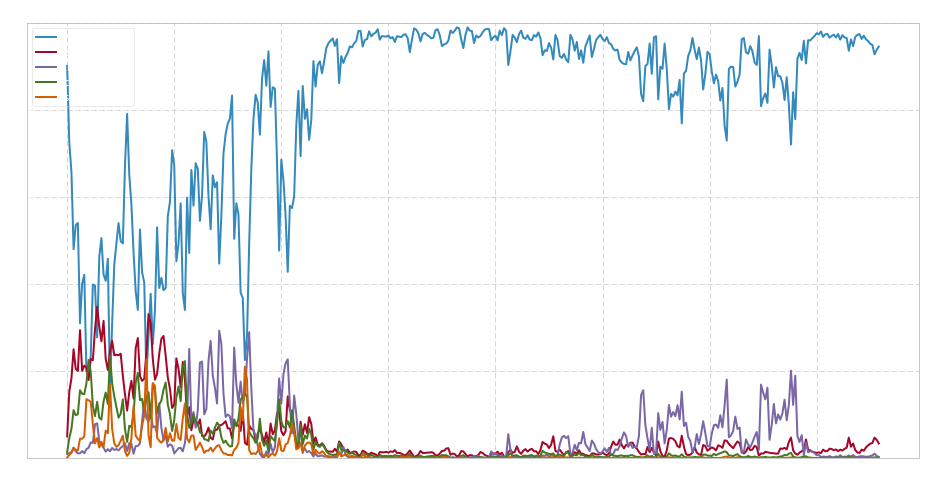

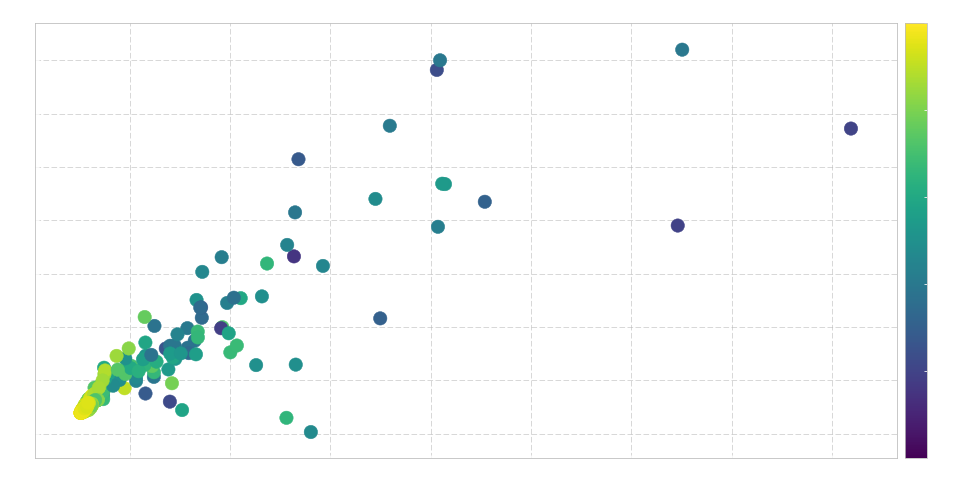

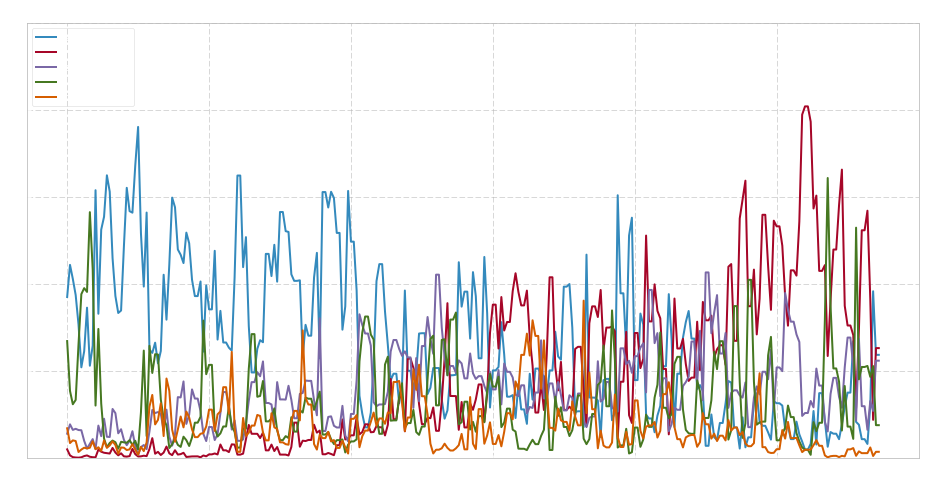

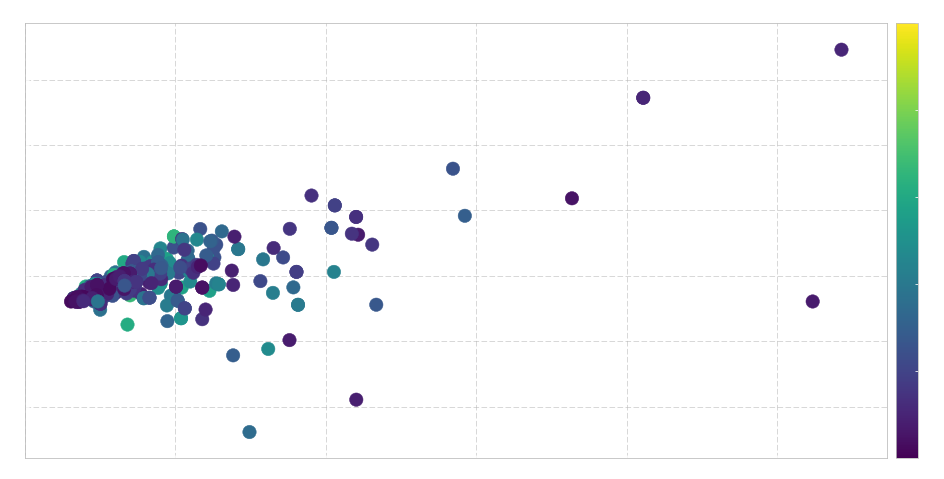

In [16]:
import itertools
marker = itertools.cycle(('>', (5, 0), (5, 1), (5, 2)))

# draw all car_embedding,
# video probability over frame index
# video bubble and embedding probability
i = 0
fig_count = 2
for a_key in embedding_and_probs_dict['car'].keys():
    # prepare the data
    prob_mat = embedding_and_probs_dict['car'][a_key]['prb']
    samples = prob_mat.size(0)
    video_mean_prob = prob_mat.mean(dim=0).squeeze()
    top_n_ind = get_top_n_idx(video_mean_prob, 5)
    top_n_classes = prob_mat.index_select(1, top_n_ind)
    top_n_classes_np = top_n_classes.numpy()
    
    ### figure 2k, k > 1 ###################
    plt.figure(fig_count); fig_count += 1
    plt.plot(top_n_classes_np)
    plt.ylim((0, 1))
    plt.legend([classes[idx] for idx in top_n_ind], loc='upper left');
    plt.title(a_key)

    ### figure 2k+1, k > 1 #################
    plt.figure(fig_count); fig_count += 1
    plt.plot(mlab_pca.Y[i:i+samples,0],mlab_pca.Y[i:i+samples,1], c='white', linewidth=0.25, zorder=1)
    plt.scatter(mlab_pca.Y[i:i+samples,0],mlab_pca.Y[i:i+samples,1], c=top_n_classes_np[:,0],
                s=180, vmin=0, vmax=1, zorder=2)
    plt.colorbar(fraction=0.025, pad=0.01)
    plt.title(a_key)
    
    ### figure 1 ###########################
    plt.figure(1)
    plt.scatter(mlab_pca.Y[i:i+samples,0],mlab_pca.Y[i:i+samples,1], marker=next(marker), label=a_key)
    i += samples

plt.legend()
plt.title('car space')

In [18]:
frame_prg_bar = IntProgress(min=0, max=0, description='frame'); display(frame_prg_bar)
video_name = 'V60722-153427'
video_path = 'data/sampled-data/val/car-V60722-153427/5.mp4'
video_file = FFmpegReader(video_path)
frames_nb = video_file.getShape()[0]
my_probabilities = list()

frame_prg_bar.max = frames_nb
frame_prg_bar.value = 0
frame_prg_bar.description = 'frame 1/' + str(frames_nb)

for frame in video_file.nextFrame():
    frame_prg_bar.description = 'frame ' + str(frame_prg_bar.value+1) + '/' + str(frames_nb)
    x = V(pre_proc(frame).unsqueeze(0).cuda(), volatile=True)
    logit = resnet_18(x)
    my_probabilities.append(softmax(logit).data)
    frame_prg_bar.value += 1
    # hack for buggy video files
    if video_name == 'V60722-191627.mp4' and frame_prg_bar.value + 1 == frames_nb: break

probs = torch.cat(my_probabilities, 0).cpu()
video_prg_bar.value += 1

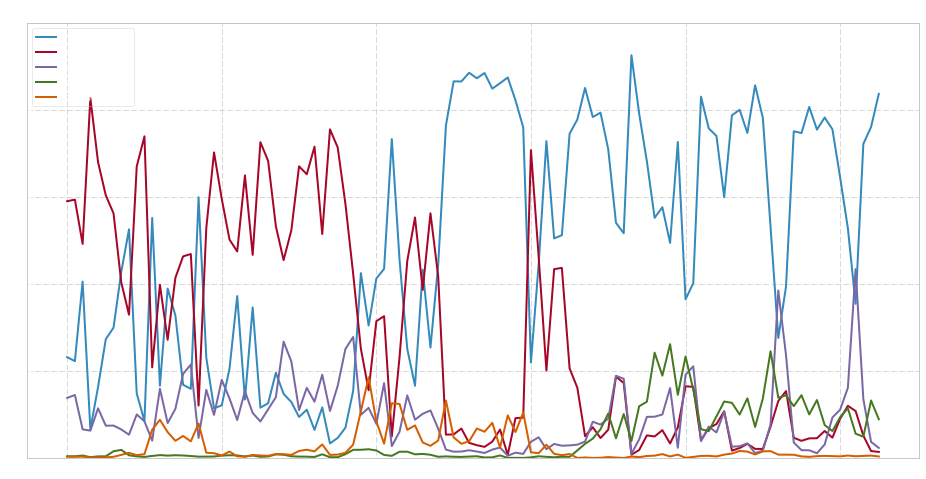

In [19]:
# prepare the data
prob_mat = probs
samples = prob_mat.size(0)
video_mean_prob = prob_mat.mean(dim=0).squeeze()
top_n_ind = get_top_n_idx(video_mean_prob, 5)
top_n_classes = prob_mat.index_select(1, top_n_ind)
top_n_classes_np = top_n_classes.numpy()

plt.plot(top_n_classes_np)
plt.ylim((0, 1))
plt.legend([classes[idx] for idx in top_n_ind], loc='upper left');
plt.title(a_key)


In [17]:
embedding_and_probs_dict['car'].keys()

dict_keys(['IMG_3114.MOV', 'V60722-153513.mp4', 'V60722-190605.mp4', 'V60722-190302.mp4', 'V60722-191627.mp4', '20160603_133515.mp4', '20160706_180451.mp4', 'V60722-153720.mp4', 'V60722-190820.mp4', 'V60722-190631.mp4', 'PIC_10265721554095715992.MOV', 'V60722-153449.mp4', 'V60722-153427.mp4', 'V60722-190739.mp4', 'V60722-154202.mp4', 'V60722-153743.mp4', 'video_20160722_190554.mp4', 'video_20160722_153539.mp4', 'V60722-191454.mp4', 'V60722-191709.mp4', 'V60722-153539.mp4', 'V60722-190716.mp4', 'V60722-191413.mp4'])